# Bitcoin Price Prediction - Documentation
## BS Data Science Project - Recurrent Bitcoin Network

This notebook contains a brief documentation on retrieving data from [Messari](https://messari.io/) through its web [API](https://messari.io/api/docs).

### Prerequesites

Before running this notebook, several python packages are needed to be installed as shown in the following cell. In addition, changing of working directory within the local repository was done.

### License

This notebook is licensed under GNU General Public License v3.0. See `LICENSE` in the project root for details.

In [1]:
# Built-in packages
import os
from datetime import datetime

In [2]:
os.chdir('../src')

In [3]:
# Packages to be installed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

%matplotlib inline
sns.set()
sns.set_context('talk')

# Local python functions
import collect
import pipeline
import plotting

In [4]:
%load_ext tensorboard

In [5]:
# Notebook Execution Time
print('Current time: {}'.format(datetime.now()))

Current time: 2022-04-14 01:05:30.735755


In [6]:
# Use this cell if you intend to apply your Messari API key
# os.environ['MESSARI_API_KEY'] = <insert_key_here>

In [7]:
'MESSARI_API_KEY' in os.environ

False

In [8]:
collector = collect.MessariCollector(api_key=os.getenv('MESSARI_API_KEY'))

### Data
The expected data would be a data frame of time series data denoted by its columns and it would be splitted, normalized, and be fed for model training and testing. In this project, we would only use daily time series data from 2017 to 2020 as the training set, while 2021 data would be used as a test set.

The following table below shows a sample of metrics to be used as features for Bitcoin price forecasting, along with their descriptions and sources. For full list of metrics, see `metrics.csv`.

In [9]:
df_metrics = collector.get_metrics()
df_metrics.data.to_csv('../raw/metrics.csv')
df_metrics.data

,name,description,minimum_interval,role_restriction,source_name,source_url
metric_id,,,,,,
act.addr.cnt,Active Addresses Count,The sum count of unique addresses that were ac...,1d,NaN,Coinmetrics,https://coinmetrics.io
addr.act.rcv.cnt,Active Addresses Count (Received),The sum count of unique addresses that were ac...,1d,"[pro, enterprise]",Coinmetrics,https://coinmetrics.io
addr.act.sent.cnt,Active Addresses Count (Sent),The sum count of unique addresses that were ac...,1d,"[pro, enterprise]",Coinmetrics,https://coinmetrics.io
addr.bal.0.001.ntv.cnt,Addresses with balance greater than 0.001 nati...,The sum count of unique addresses holding at l...,1d,"[pro, enterprise]",Coinmetrics,https://coinmetrics.io
addr.bal.0.01.ntv.cnt,Addresses with balance greater than 0.01 nativ...,The sum count of unique addresses holding at l...,1d,"[pro, enterprise]",Coinmetrics,https://coinmetrics.io
...,...,...,...,...,...,...
utxo.age.med,Median UTXO Age,The median age in full days of all unspent tra...,1d,"[pro, enterprise]",Coinmetrics,https://coinmetrics.io
utxo.age.val.avg,Value-weighted Average UTXO Age,The value-weighted average age in full days of...,1d,"[pro, enterprise]",Coinmetrics,https://coinmetrics.io
utxo.cnt,UTXO Count,The sum count of unspent transaction outputs t...,1d,"[pro, enterprise]",Coinmetrics,https://coinmetrics.io


In [10]:
btc_metrics = df_metrics.data.copy()
btc_metrics = btc_metrics[btc_metrics['role_restriction'].isna()]

In [11]:
selected_metrics = [
    'act.addr.cnt', 'blk.cnt', 'daily.shp', 'daily.vol',
    'nvt.adj.90d.ma', 'price', 'txn.cnt',
    'txn.tsfr.cnt',
]

In [12]:
# btc_metrics.drop(metrics_to_remove, inplace=True)
btc_metrics = btc_metrics.loc[selected_metrics]

In [13]:
btc_metrics.to_csv('../raw/bitcoin_metrics.csv')

In [14]:
print(f'Number of metrics: {btc_metrics.shape[0]}')
btc_metrics

Number of metrics: 8


,name,description,minimum_interval,role_restriction,source_name,source_url
metric_id,,,,,,
act.addr.cnt,Active Addresses Count,The sum count of unique addresses that were ac...,1d,NaN,Coinmetrics,https://coinmetrics.io
blk.cnt,Block Count,The sum count of blocks created each day,1d,NaN,Coinmetrics,https://coinmetrics.io
daily.shp,Sharpe Ratio,The Sharpe ratio (performance of the asset com...,1d,NaN,Kaiko,https://www.kaiko.com/
daily.vol,Volatility,The annualized standard-deviation of daily ret...,1d,NaN,Kaiko,https://www.kaiko.com/
nvt.adj.90d.ma,Adjusted NVT 90-days MA,The ratio of the network value (or market capi...,1d,NaN,Coinmetrics,https://coinmetrics.io
price,Price,Volume weighted average price computed using M...,1m,NaN,Kaiko,https://www.kaiko.com/
txn.cnt,Transactions Count,The sum count of transactions that interval. T...,1d,NaN,Coinmetrics,https://coinmetrics.io
txn.tsfr.cnt,Transactions Transfer Count,The sum count of transfers that interval. Tran...,1d,NaN,Coinmetrics,https://coinmetrics.io


In [15]:
# Data Sources
btc_metrics['source_name'].unique()

array(['Coinmetrics', 'Kaiko'], dtype=object)

### Retrieve Time Series Data

In this section, we would retrieve time series data with the given metrics retrieved above. A script was implemented to automate the data collection process.

In [16]:
try:
    train_df = pd.read_csv('../raw/train.csv', parse_dates=['timestamp'])
except FileNotFoundError:
    if not os.path.exists('../raw'):
        os.mkdir('../raw')

    train_raw = collector.get_batch_data(
        assetkey='BTC',
        metrics=btc_metrics.index,
        start='2016-01-01',
        end='2020-12-31'
    )
    train_df = pd.concat(
        [resp.get_melt_data() for resp in train_raw],
        ignore_index=True
    )
    train_df.to_csv('../raw/train.csv', index=False)

In [17]:
try:
    test_df = pd.read_csv('../raw/test.csv', parse_dates=['timestamp'])
except FileNotFoundError:
    if not os.path.exists('../raw'):
        os.mkdir('../raw')

    test_raw = collector.get_batch_data(
        assetkey='BTC',
        metrics=btc_metrics.index,
        start='2021-01-01',
        end='2021-06-30'
    )
    test_df = pd.concat(
        [resp.get_melt_data() for resp in test_raw],
        ignore_index=True
    )
    test_df.to_csv('../raw/test.csv', index=False)

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32886 entries, 0 to 32885
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  32886 non-null  datetime64[ns]
 1   metric     32886 non-null  object        
 2   submetric  32886 non-null  object        
 3   value      32886 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.0+ MB


In [19]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3258 entries, 0 to 3257
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  3258 non-null   datetime64[ns]
 1   metric     3258 non-null   object        
 2   submetric  3258 non-null   object        
 3   value      3258 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 101.9+ KB


### Data Transformation

We would convert the given time series data from a long format to a wide format.

In [20]:
wide_train = train_df.pivot_table(
    index='timestamp',
    columns=['metric', 'submetric'],
    values='value'
)

prices_train = wide_train.pop('price')
wide_train['price', 'close'] = prices_train['close']

In [21]:
wide_test = test_df.pivot_table(
    index='timestamp',
    columns=['metric', 'submetric'],
    values='value'
)

prices_test = wide_test.pop('price')
wide_test['price', 'close'] = prices_test['close']

In [22]:
wide_train.head()

metric         act.addr.cnt     blk.cnt  daily.shp                        \
submetric  active_addresses block_count sharpe_1yr sharpe_30d sharpe_3yr   
timestamp                                                                  
2016-01-01         316781.0       135.0   0.869196   3.254284   1.604864   
2016-01-02         417966.0       145.0   0.903431   3.742549   1.609291   
2016-01-03         398443.0       145.0   0.885630   3.463730   1.612791   
2016-01-04         413159.0       181.0   1.075561   3.520499   1.612907   
2016-01-05         435291.0       157.0   1.157387   2.312140   1.609834   

metric                     daily.vol                                \
submetric  sharpe_90d volatility_1yr volatility_30d volatility_3yr   
timestamp                                                            
2016-01-01   3.685772       0.685757       0.640308       1.028978   
2016-01-02   3.635713       0.685251       0.631588       1.028922   
2016-01-03   3.592289       0.685339       0.633846       1.028857   
2016-01-04   3.596404       0.675956       0.633926       1.028857   
2016-01-05   3.442895       0.673562       0.592641       1.028863   

metric                         nvt.adj.90d.ma           txn.cnt  \
submetric  volatility_90d nvt_adjusted_90d_ma transaction_count   
timestamp                                                         
2016-01-01       0.677785           41.147256          124427.0   
2016-01-02       0.678005           41.048731          147864.0   
2016-01-03       0.678520           40.644184          145029.0   
2016-01-04       0.678528           40.918827          178576.0   
2016-01-05       0.677822           40.754906          183659.0   

metric        txn.tsfr.cnt       price  
submetric  transfers_count       close  
timestamp                               
2016-01-01        320580.0  433.960345  
2016-01-02        405602.0  433.221343  
2016-01-03        432531.0  429.132867  
2016-01-04        419538.0  433.152291  
2016-01-05        438135.0  432.001391

In [23]:
wide_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2016-01-01 to 2020-12-31
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   (act.addr.cnt, active_addresses)       1827 non-null   float64
 1   (blk.cnt, block_count)                 1827 non-null   float64
 2   (daily.shp, sharpe_1yr)                1827 non-null   float64
 3   (daily.shp, sharpe_30d)                1827 non-null   float64
 4   (daily.shp, sharpe_3yr)                1827 non-null   float64
 5   (daily.shp, sharpe_90d)                1827 non-null   float64
 6   (daily.vol, volatility_1yr)            1827 non-null   float64
 7   (daily.vol, volatility_30d)            1827 non-null   float64
 8   (daily.vol, volatility_3yr)            1827 non-null   float64
 9   (daily.vol, volatility_90d)            1827 non-null   float64
 10  (nvt.adj.90d.ma, nvt_adjusted_90d_ma)  1827 non-null  

In [24]:
prices_train.head()

submetric,close,high,low,open,volume
timestamp,,,,,
2016-01-01,433.960345,437.841344,426.068766,430.206620,2.099646e+07
2016-01-02,433.221343,436.820867,431.542401,434.015456,1.393225e+07
2016-01-03,429.132867,433.727409,422.757469,433.212063,2.396948e+07
2016-01-04,433.152291,435.231337,428.233668,429.401480,2.528594e+07
2016-01-05,432.001391,434.548442,428.386082,432.978697,1.956450e+07


In [25]:
wide_test.head()

metric         act.addr.cnt     blk.cnt  daily.shp                        \
submetric  active_addresses block_count sharpe_1yr sharpe_30d sharpe_3yr   
timestamp                                                                  
2021-01-01        1001890.0       149.0   2.155131   8.298569   0.348882   
2021-01-02        1140633.0       151.0   2.227206   9.182984   0.393070   
2021-01-03        1184688.0       158.0   2.227079  10.845058   0.389926   
2021-01-04        1270082.0       173.0   2.147672   8.671640   0.316454   
2021-01-05        1230529.0       157.0   2.147846   9.762872   0.331617   

metric                     daily.vol                                \
submetric  sharpe_90d volatility_1yr volatility_30d volatility_3yr   
timestamp                                                            
2021-01-01   7.383160       0.753934       0.631271       0.762070   
2021-01-02   7.684719       0.760788       0.725350       0.765063   
2021-01-03   7.769999       0.757727       0.657062       0.764035   
2021-01-04   7.363521       0.760406       0.708616       0.761901   
2021-01-05   7.770842       0.756858       0.676053       0.761347   

metric                         nvt.adj.90d.ma           txn.cnt  \
submetric  volatility_90d nvt_adjusted_90d_ma transaction_count   
timestamp                                                         
2021-01-01       0.592639          117.977582          261318.0   
2021-01-02       0.630282          125.420388          297595.0   
2021-01-03       0.615764          128.553868          359641.0   
2021-01-04       0.629533          120.732416          370865.0   
2021-01-05       0.618479          127.138194          355008.0   

metric        txn.tsfr.cnt         price  
submetric  transfers_count         close  
timestamp                                 
2021-01-01        745255.0  29402.176951  
2021-01-02        846740.0  32200.200909  
2021-01-03        957490.0  33061.908711  
2021-01-04       1009564.0  32013.657608  
2021-01-05       1005028.0  34033.028441

In [26]:
wide_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 181 entries, 2021-01-01 to 2021-06-30
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   (act.addr.cnt, active_addresses)       181 non-null    float64
 1   (blk.cnt, block_count)                 181 non-null    float64
 2   (daily.shp, sharpe_1yr)                181 non-null    float64
 3   (daily.shp, sharpe_30d)                181 non-null    float64
 4   (daily.shp, sharpe_3yr)                181 non-null    float64
 5   (daily.shp, sharpe_90d)                181 non-null    float64
 6   (daily.vol, volatility_1yr)            181 non-null    float64
 7   (daily.vol, volatility_30d)            181 non-null    float64
 8   (daily.vol, volatility_3yr)            181 non-null    float64
 9   (daily.vol, volatility_90d)            181 non-null    float64
 10  (nvt.adj.90d.ma, nvt_adjusted_90d_ma)  181 non-null    

In [27]:
prices_test.head()

submetric,close,high,low,open,volume
timestamp,,,,,
2021-01-01,29402.176951,29674.366390,28692.320100,28963.116282,5.206879e+09
2021-01-02,32200.200909,33268.527789,29022.584583,29394.914671,1.150113e+10
2021-01-03,33061.908711,34810.548275,31984.603073,32209.643507,1.151527e+10
2021-01-04,32013.657608,33686.591916,27902.210046,32979.561700,1.317324e+10
2021-01-05,34033.028441,34495.109124,29915.527058,31983.572856,1.084223e+10


### Exploratory Data Analysis

In [28]:
corr_data = wide_train.corr().sort_values(by=('price','close'), ascending=False)
corr_data['price','close'].to_csv('../raw/corr_results.csv')

In [29]:
corr_data['price','close']

metric          submetric          
price           close                  1.000000
nvt.adj.90d.ma  nvt_adjusted_90d_ma    0.738545
act.addr.cnt    active_addresses       0.736091
txn.tsfr.cnt    transfers_count        0.592143
daily.vol       volatility_1yr         0.533678
txn.cnt         transaction_count      0.390861
daily.vol       volatility_90d         0.276180
                volatility_30d         0.255684
daily.shp       sharpe_90d             0.123329
                sharpe_3yr             0.116584
                sharpe_30d             0.065534
daily.vol       volatility_3yr         0.004811
blk.cnt         block_count            0.001748
daily.shp       sharpe_1yr            -0.036384
Name: (price, close), dtype: float64

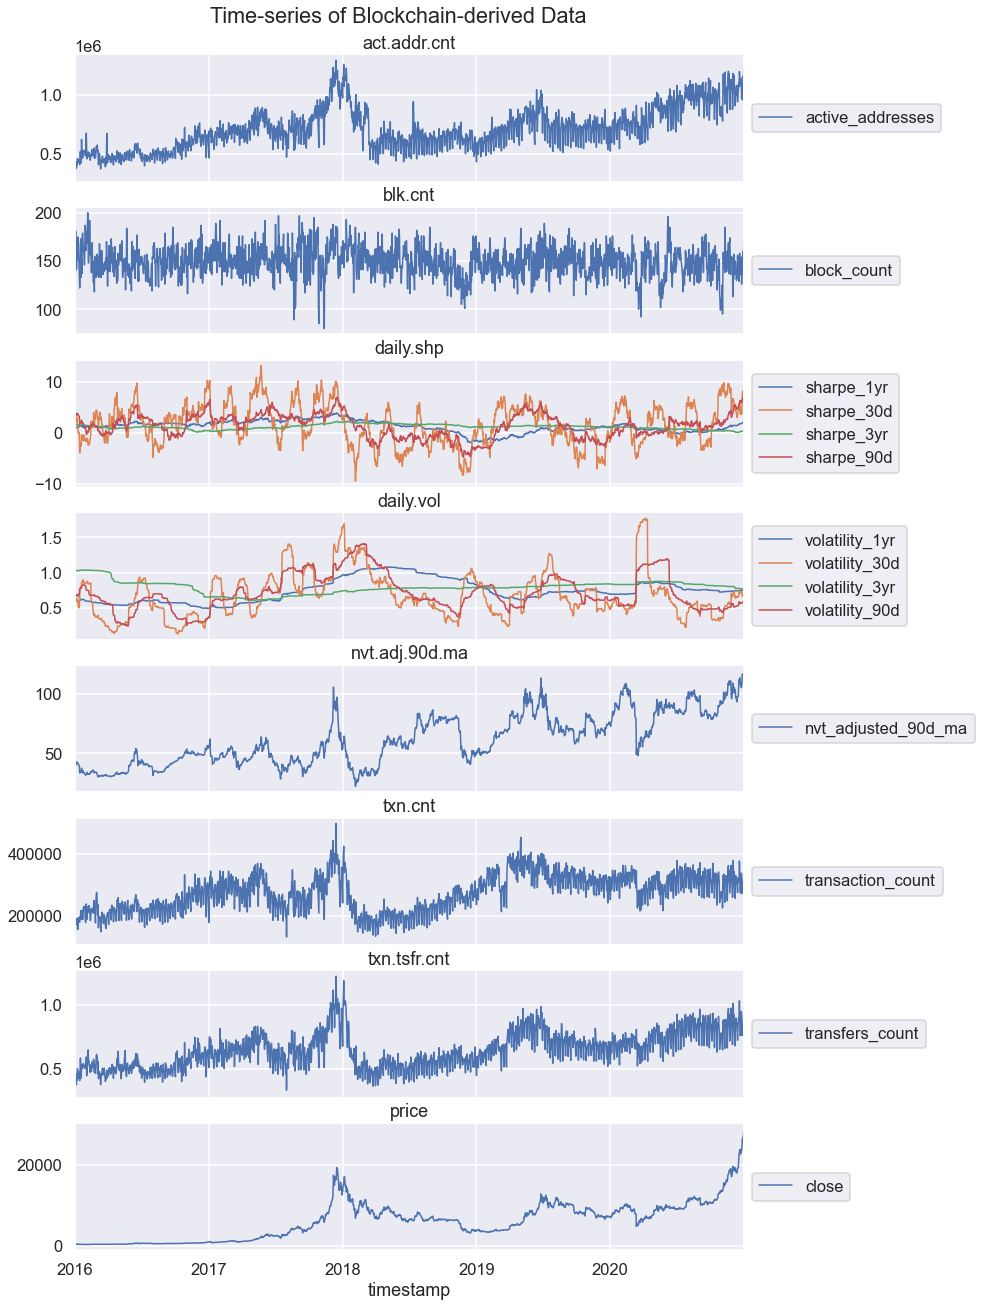

In [30]:
fig, ax = plotting.plot_timeseries_data(wide_train)

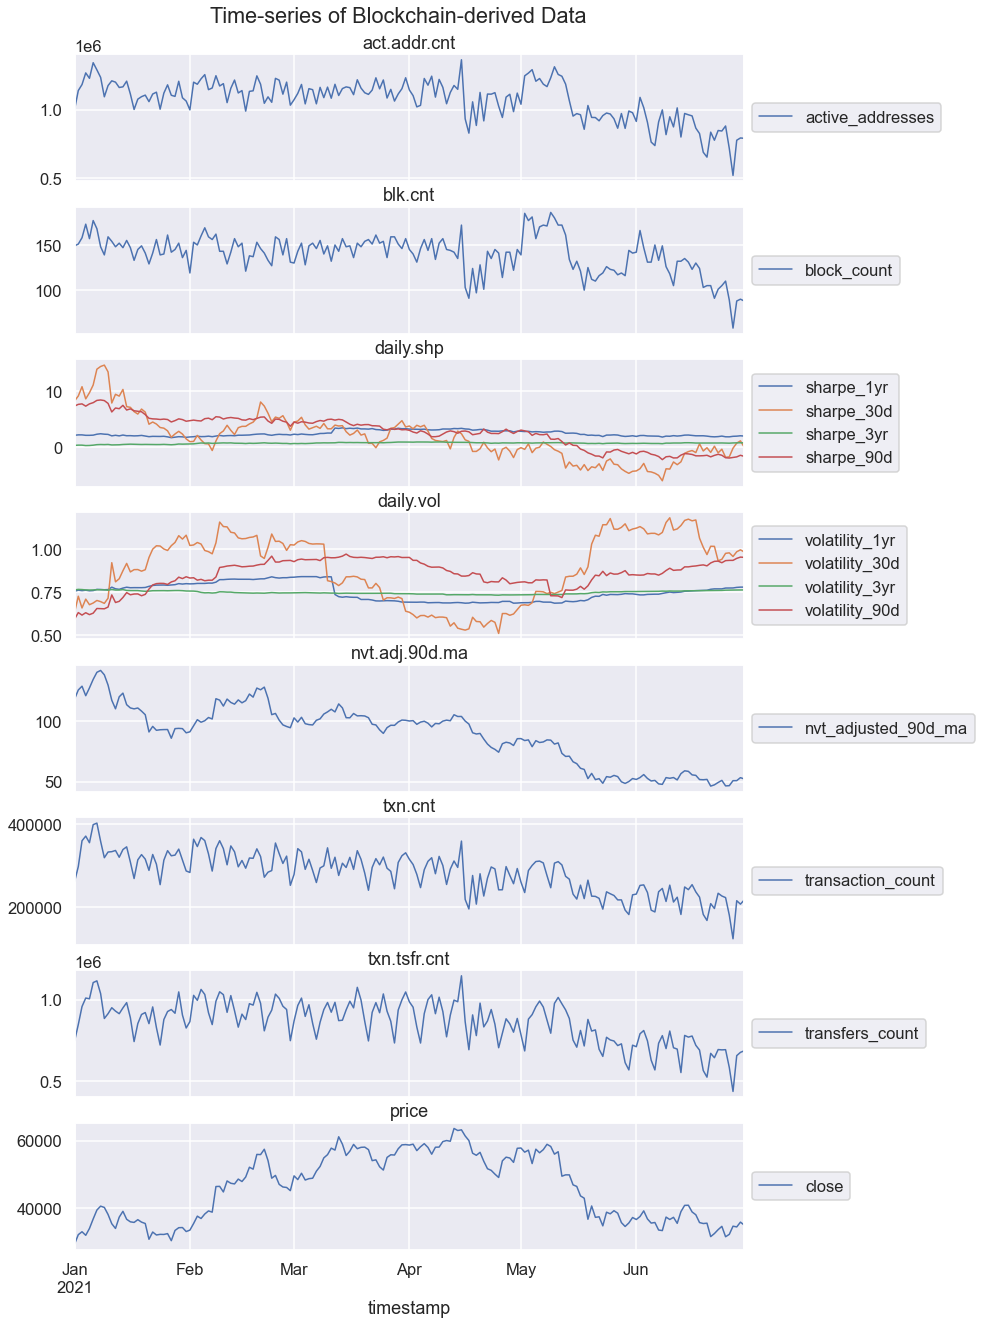

In [31]:
fig, ax = plotting.plot_timeseries_data(wide_test)

### Predictive Modeling

In [32]:
config_path = '../config/model.ini'

In [33]:
mainmodel = pipeline.load_pipeline(filepath=config_path, section='BASEMODEL')

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_encoder (InputLayer)  [(None, 21, 14)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 21, 250)          140000    
 l)                                                              
                                                                 
Total params: 140,000
Trainable params: 140,000
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_decoder (InputLayer)  [(None, 21, 250)]         0         
                                                                 
 decoder_lstm (LSTM)         (None, 21, 75)            97800     
                                    

In [34]:
svdmodel1 = pipeline.load_pipeline(filepath=config_path, section='SVDMODEL1')

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_encoder (InputLayer)  [(None, 21, 5)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 21, 250)          131000    
 nal)                                                            
                                                                 
Total params: 131,000
Trainable params: 131,000
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_decoder (InputLayer)  [(None, 21, 250)]         0         
                                                                 
 decoder_lstm (LSTM)         (None, 21, 75)            97800     
                                    

In [35]:
svdmodel2 = pipeline.load_pipeline(filepath=config_path, section='SVDMODEL2')

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_encoder (InputLayer)  [(None, 21, 2)]           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 21, 250)          128000    
 nal)                                                            
                                                                 
Total params: 128,000
Trainable params: 128,000
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_decoder (InputLayer)  [(None, 21, 250)]         0         
                                                                 
 decoder_lstm (LSTM)         (None, 21, 75)            97800     
                                    

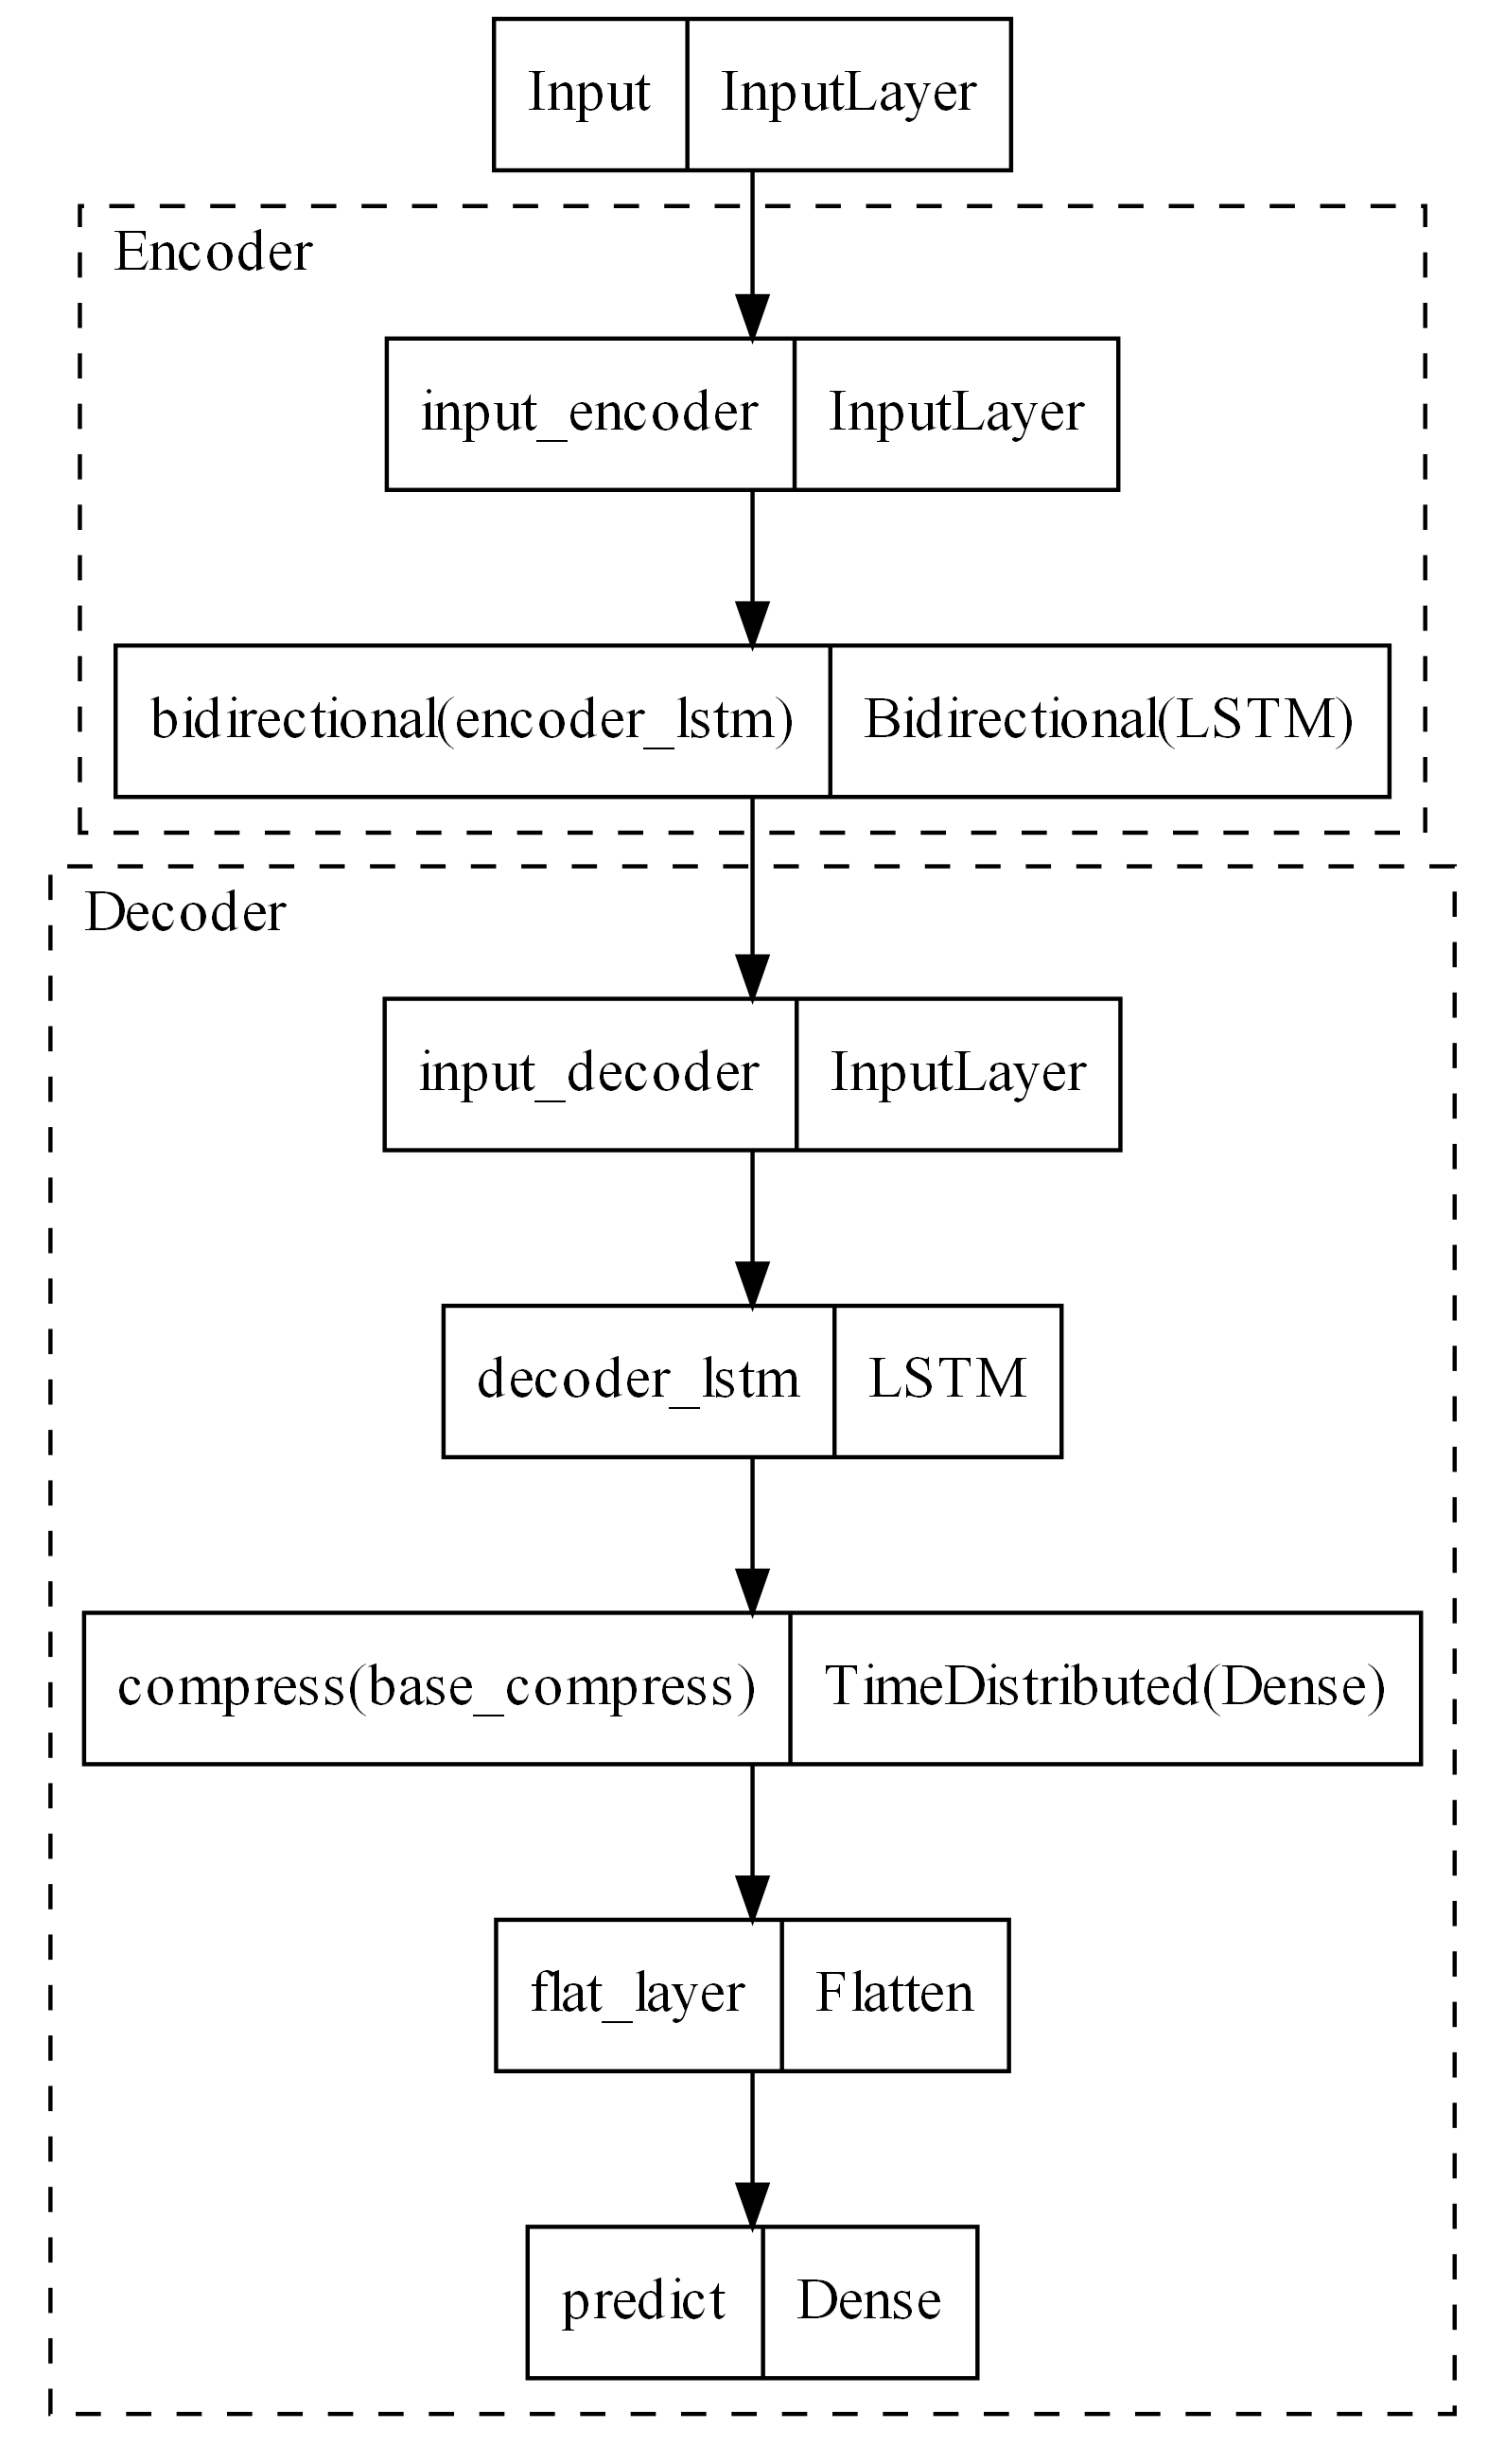

In [36]:
tf.keras.utils.plot_model(
    mainmodel.tfmodel,
    to_file='../raw/model.png',
    expand_nested=True,
    dpi=320
)

In [37]:
# To be used for reloading the weights for extended training
# Comment out if necessary

mainmodel.reload()
svdmodel1.reload()
svdmodel2.reload()

In [38]:
hist_base = mainmodel.model_train(
    xtrain=wide_train,
    ytrain=prices_train['close'],
    xtest=wide_test,
    ytest=prices_test['close'],
    epochs=500,
    verbose=0
)

In [39]:
hist_svd1 = svdmodel1.model_train(
    xtrain=wide_train,
    ytrain=prices_train['close'],
    xtest=wide_test,
    ytest=prices_test['close'],
    epochs=500,
    verbose=0
)

In [40]:
hist_svd2 = svdmodel2.model_train(
    xtrain=wide_train,
    ytrain=prices_train['close'],
    xtest=wide_test,
    ytest=prices_test['close'],
    epochs=500,
    verbose=0
)

In [41]:
nosvd_results = hist_base.show_results()
svd1_results = hist_svd1.show_results()
svd2_results = hist_svd2.show_results()

rmse_data = pd.concat(
    [nosvd_results, svd1_results, svd2_results],
    ignore_index=True
)
rmse_data.to_csv('../raw/performance.csv', index=False)

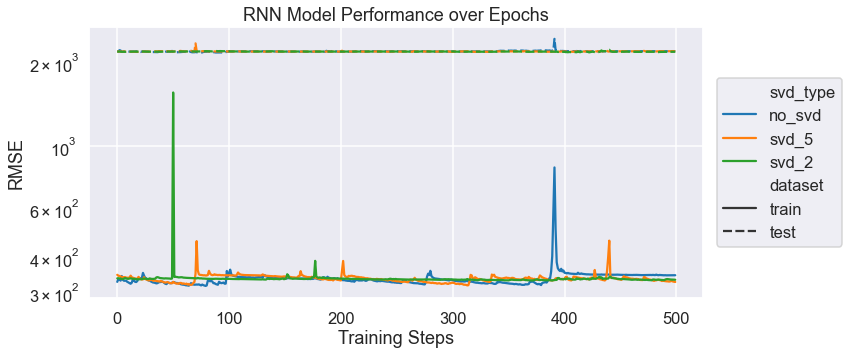

In [42]:
fig, ax = plt.subplots(figsize=(11, 5))
sns.lineplot(data=rmse_data, x='epoch', y='RMSE',
             hue='svd_type', style='dataset',
             markers=False, palette='tab10',
             style_order=['train', 'test'],
             hue_order=['no_svd', 'svd_5', 'svd_2'],
             ax=ax)

ax.set_xlabel('Training Steps')
ax.set_yscale('log')
ax.set_title('RNN Model Performance over Epochs')
ax.legend(loc='right', ncol=1, bbox_to_anchor=(1.24, 0.5))
fig.savefig('../raw/performance.png', bbox_inches='tight')

### Model Predictions

In [43]:
def plot_all_preds(date):
    fig, ax = plt.subplots(figsize=(12,5))
    xtest, ytest = mainmodel.plotfunc.select_data(date)
    ax = ytest.plot(color='black')
    ax = mainmodel.plot_predict(date, color='blue', label='no_svd',
                                return_preds_only=True)
    ax = svdmodel1.plot_predict(date, color='orange', label='svd_5',
                                return_preds_only=True)
    ax = svdmodel2.plot_predict(date, color='green', label='svd_2',
                                return_preds_only=True)

    ax.set_xlabel('Date')
    ax.set_ylabel('Price (USD)')
    ax.set_title('Bitcoin Price Forecast')
    ax.legend()

    return fig, ax

(<Figure size 864x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Bitcoin Price Forecast'}, xlabel='Date', ylabel='Price (USD)'>)

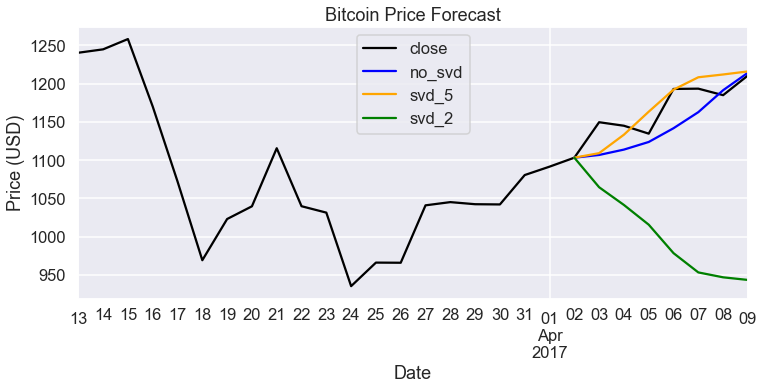

In [44]:
plot_all_preds('2017-03-13')

(<Figure size 864x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Bitcoin Price Forecast'}, xlabel='Date', ylabel='Price (USD)'>)

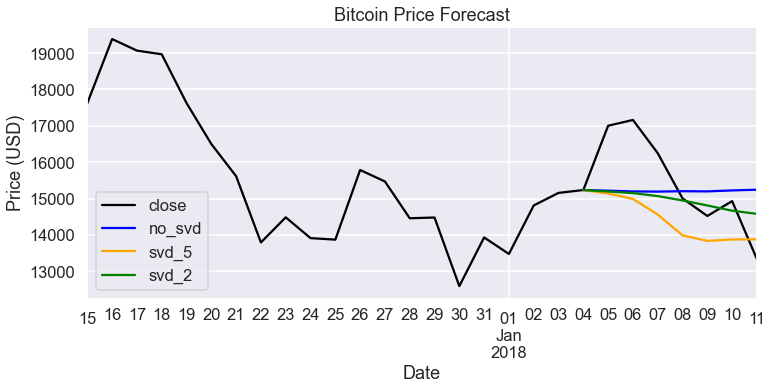

In [45]:
plot_all_preds('2017-12-15')

(<Figure size 864x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Bitcoin Price Forecast'}, xlabel='Date', ylabel='Price (USD)'>)

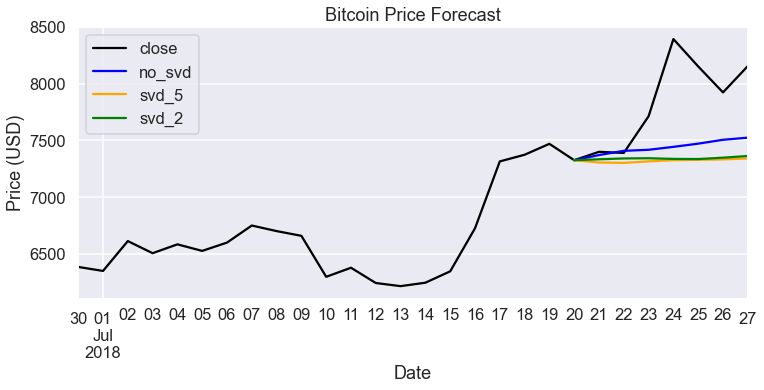

In [46]:
plot_all_preds('2018-06-30')

(<Figure size 864x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Bitcoin Price Forecast'}, xlabel='Date', ylabel='Price (USD)'>)

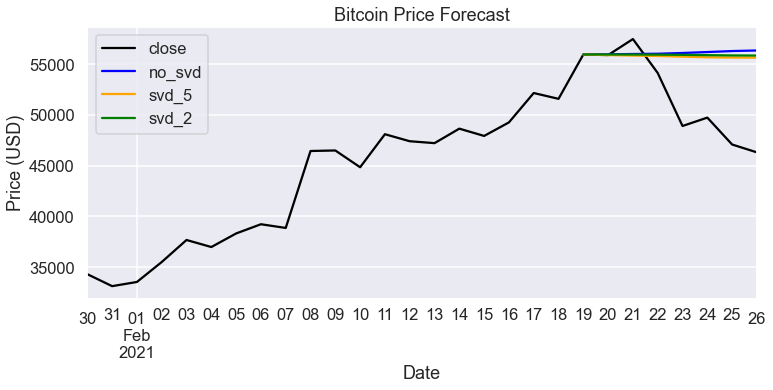

In [47]:
plot_all_preds('2021-1-30')

(<Figure size 864x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Bitcoin Price Forecast'}, xlabel='Date', ylabel='Price (USD)'>)

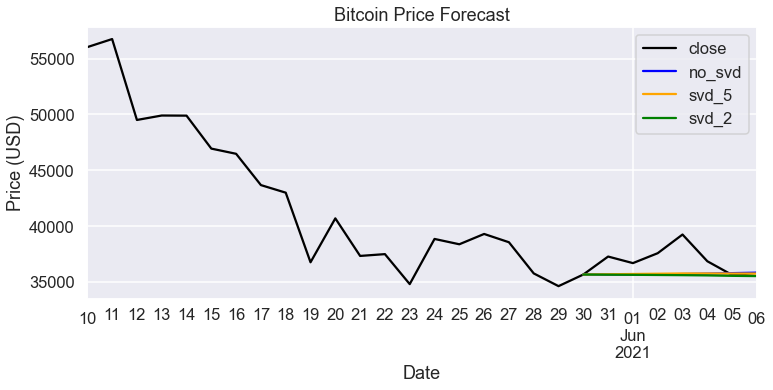

In [48]:
plot_all_preds('2021-05-10')